# Prerequisites
- Collection data
- Import packages

In [1]:
!pip install torchmetrics
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 13.4 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
# Torch vision for data loaders and data sets
import torchvision
from torchvision import datasets
# pyplot for plotting the dataset
import matplotlib.pyplot as plt

print(f"Pytorch version : {torch.__version__} and torchvision version {torchvision.__version__}")




Pytorch version : 2.5.1+cu121 and torchvision version 0.20.1+cu121


In [3]:
# load fashhionMNISt data set from the torchvision.datasets

# Training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

# Testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)



100%|██████████| 26.4M/26.4M [00:01<00:00, 16.9MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 399kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.62MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.6MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
# checking the training data
image, label = train_data[0]

print(f"image shape [1,28,28] represents color channel, height and width of the image")
image.shape, label


image shape [1,28,28] represents color channel, height and width of the image


(torch.Size([1, 28, 28]), 9)

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

(-0.5, 27.5, 27.5, -0.5)

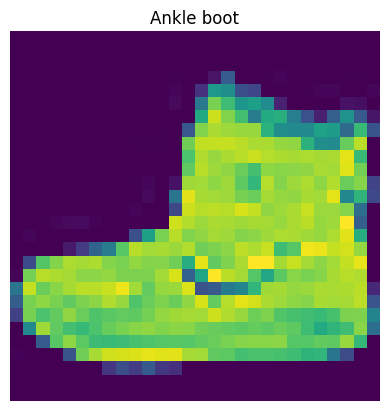

In [6]:
# let's try to visualise our first image using plt

plt.imshow(image.squeeze())
plt.title(class_names[label])

plt.axis(False) # To disable the axis

(-0.5, 27.5, 27.5, -0.5)

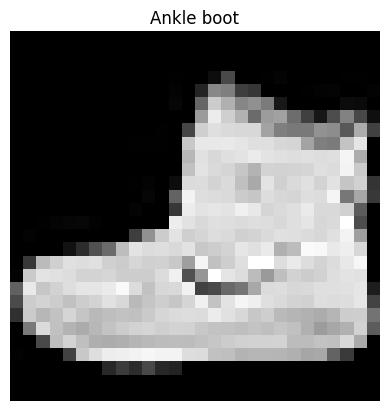

In [7]:
# we can also convert the image to grey
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

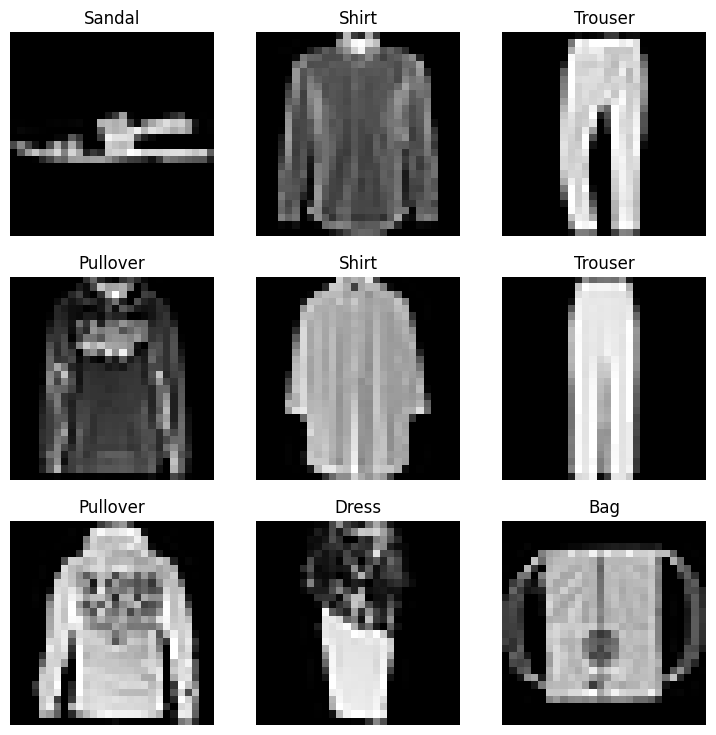

In [8]:
# Let's try to have some subplots for visualising random 10 datasets

# create a plt fig for a specific size, say (9,9)
fig = plt.figure(figsize=(9,9))
rows, col = 3,3
for i in range(1, rows*col +1): #1 to 10
  ## take randome image from the train dataset using torch randint
  random_index = torch.randint(0,len(train_data), size=[1]).item()
  img, lb = train_data[random_index] # img contrain the image (1, 28,28) and lb contains label like 1, 2, 3
  fig.add_subplot(rows, col, i) # add the
  plt.imshow(img.squeeze(), cmap='grey')
  plt.title(class_names[lb])
  plt.axis(False)

In [9]:
# now we should prepare some data for model to process
# we need to use dataloader from the torch.utils.data.DataLoader because, it is easy to process
# data in batches rather whole data at one
# dataloader create python iterable of small chunks
# it create mini batches of the dataset
# Usual batch size is 32

BATCH_SIZE = 32
MANUAL_SEED = 42
from torch.utils.data import DataLoader


train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")



Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7bdf96ab1250>, <torch.utils.data.dataloader.DataLoader object at 0x7bdf947a8150>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [10]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape
# it represent there are 32 batch of format [1,28,28]

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [11]:
# Creating our model
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_size, hidden_units, output_size):
    super().__init__()
    # creating out layers
    self.layer_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_size,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )

    self.layer_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )

    self.flattening_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 7 * 7,
                  out_features=output_size)
    )

  def forward(self, x: torch.Tensor):
    return self.flattening_layer(self.layer_2(self.layer_1(x)))


model = FashionMNISTModelV0(
    input_size = 1,
    hidden_units = 10,
    output_size = len(class_names)
)

model

FashionMNISTModelV0(
  (layer_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flattening_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [12]:
# choose loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.1)

loss, optimizer

(CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.1
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

# Training out model

In [13]:
# Creating train and testing function

def train_step(model_ref: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
  train_loss, train_acc = 0, 0
  for batch, (X,y) in enumerate(data_loader):
    # model.train()
    preds = model_ref(X)

    loss = loss_fn(preds, y)
    train_loss += loss;

    train_acc += accuracy_fn(preds, y)*100

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f}, Train accuracy: {train_acc:.2f}%")




def test_step(model_ref: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  test_loss, test_acc = 0, 0
  model_ref.eval()
  with torch.inference_mode():
    for batch, (X,y) in enumerate(data_loader):
      test_preds = model_ref(X)
      test_loss += loss_fn(test_preds, y)
      test_acc += accuracy_fn(test_preds, y)*100

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")



In [14]:
torch.manual_seed(MANUAL_SEED)
from timeit import default_timer as timer # for creating a time tracking
from tqdm.auto import tqdm # for tracking progress
from torchmetrics.classification import Accuracy

accuracy = Accuracy(
    task="multiclass",
    num_classes=len(class_names)
)

print(f"accuracy -> {tqdm()}")
train_time_start = timer()
# No of epochs the model should run
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  # start training
  train_step(
      model_ref=model,
      data_loader=train_dataloader,
      loss_fn=loss,
      optimizer=optimizer,
      accuracy_fn=accuracy
  )

  test_step(
      model_ref=model,
      data_loader=test_dataloader,
      loss_fn=loss,
      accuracy_fn=accuracy
  )

train_time_end = timer()

total_train_time = train_time_end - train_time_start
print(f"Total training time: {total_train_time:.3f} seconds")



0it [00:00, ?it/s]

accuracy -> 0it [00:00, ?it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59140, Train accuracy: 78.44%
Test loss: 0.37753, Test accuracy: 86.62%
Epoch: 1
---------
Train loss: 0.35259, Train accuracy: 87.38%
Test loss: 0.36682, Test accuracy: 87.39%
Epoch: 2
---------
Train loss: 0.32097, Train accuracy: 88.35%
Test loss: 0.32721, Test accuracy: 88.42%
Total training time: 208.965 seconds


# Create Evaluation model


In [15]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
  """

  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_pred, y)*100

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}


In [16]:
model_result = eval_model(
    model=model,
    data_loader=test_dataloader,
    loss_fn=loss,
    accuracy_fn=accuracy
)

model_result

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.3272061347961426,
 'model_acc': tensor(88.4185)}

Our model is predicting a 88 % accuracy which is good.


#lets make some predictions with our model

In [17]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     ):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      pred_prob = model(sample.unsqueeze(dim=0))
      pred_prob = torch.softmax(pred_prob.squeeze(), dim=0)
      pred_probs.append(pred_prob)

  return torch.stack(pred_probs)

In [18]:
import random

test_samples=[]
test_labels=[]

for sample, label in random.sample(list(test_data), k=10):
  test_samples.append(sample)
  test_labels.append(label)

print(f"test_samples: {test_samples[0].shape}")
print(f"test_labels: {test_labels}")

test_samples: torch.Size([1, 28, 28])
test_labels: [8, 9, 0, 0, 3, 5, 6, 5, 4, 3]


In [19]:
pred_probs = make_predictions(
    model=model,
    data=test_samples
)

pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([8, 9, 3, 0, 3, 5, 0, 5, 4, 3])

In [20]:
len(test_samples)

10

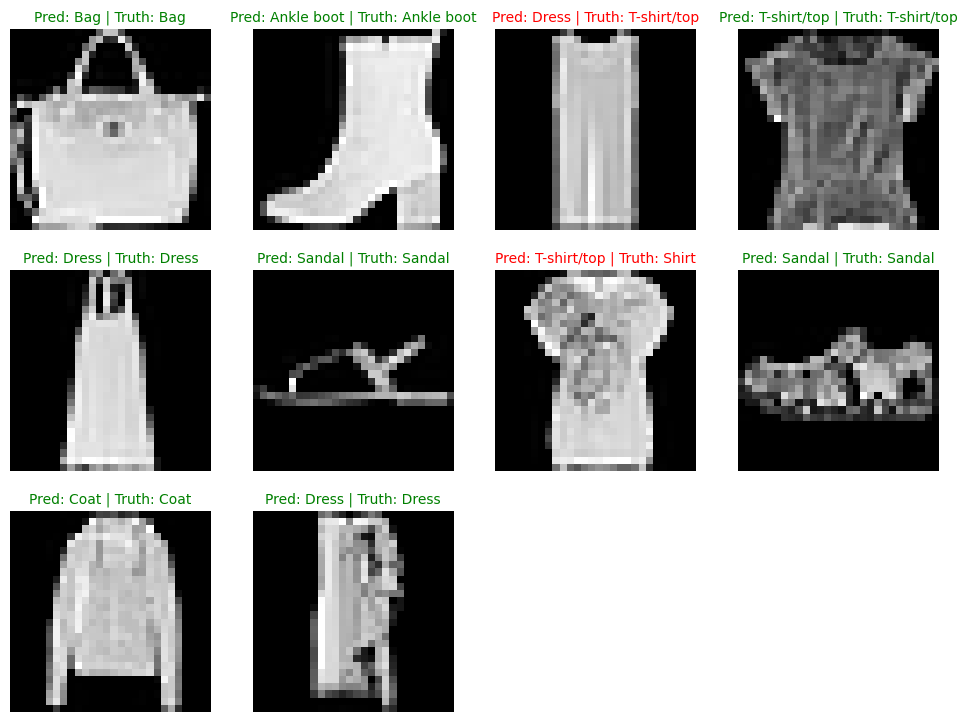

In [21]:
# Plot predictions
plt.figure(figsize=(12, 12))
nrows = 4
ncols = 4
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

# saving our model

In [22]:
model.state_dict()

OrderedDict([('layer_1.0.weight',
              tensor([[[[ 0.2277, -0.3668, -0.1527],
                        [-0.1166, -0.6005, -0.6196],
                        [-0.3736, -0.3308, -0.7038]]],
              
              
                      [[[ 0.3840, -0.0401, -0.1505],
                        [-0.9168, -0.7857,  0.0898],
                        [-0.8057, -0.7938, -0.4842]]],
              
              
                      [[[-0.0730, -0.2991, -0.3294],
                        [ 0.0247, -0.2160,  0.0406],
                        [ 0.4497,  0.1425,  0.2515]]],
              
              
                      [[[-0.1217,  0.3219,  0.3146],
                        [-0.1064,  0.1578, -0.0358],
                        [-0.3183,  0.1102,  0.1107]]],
              
              
                      [[[ 0.2184, -0.5241, -0.3104],
                        [ 0.4225,  0.4842,  0.2282],
                        [-0.0686,  0.2347,  0.0124]]],
              
              
           

In [23]:
from pathlib import Path

SAVE_FOLDER = Path("models")
SAVE_FOLDER.mkdir(parents=True, exist_ok=True)
SAVE_FILE = "01_cnn_model_with_fashionMNIST.pth"
SAVE_PATH = SAVE_FOLDER / SAVE_FILE

torch.save(obj=model.state_dict(), f=SAVE_PATH)




# confusion Metrics

In [24]:
# Prepare data for confusion metrics
from tqdm.auto import tqdm

y_preds_1 = []

model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    y_pred = model(X)
    y_preds_1.append(torch.softmax(y_pred.squeeze(), dim=0).argmax(dim=1))


#Concat the list of predictions into a tensor
y_preds_tensor = torch.cat(y_preds_1)
y_preds_tensor[:2]

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2])

In [25]:
len(y_preds_tensor)

10000

In [28]:
import torchmetrics
import mlxtend

torchmetrics.__version__, mlxtend.__version__

('1.6.1', '0.23.3')

In [30]:
# test data labels can be get using simply kley
test_data.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

In [29]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# setup the confusion instance and compare the predictions to targets
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(y_preds_tensor, test_data.targets)
confmat_tensor

tensor([[699,   3,  38,  65,   5,   0, 182,   0,   8,   0],
        [  4, 873,   8,  76,  32,   0,   5,   0,   2,   0],
        [ 12,   2, 754,  12, 145,   0,  71,   0,   4,   0],
        [ 31,  12,  14, 860,  40,   0,  35,   0,   6,   2],
        [  9,   3, 101,  63, 710,   0, 110,   0,   4,   0],
        [ 13,   2,   3,   3,   0, 790,   4,  51,  96,  38],
        [ 98,   5, 105,  67,  89,   0, 628,   0,   8,   0],
        [  1,   1,   0,   0,   0,  33,   0, 881,  20,  64],
        [ 12,   1,  15,  10,  18,   4,  41,   6, 893,   0],
        [  1,   2,   2,   2,   1,  20,   4,  58,  11, 899]])

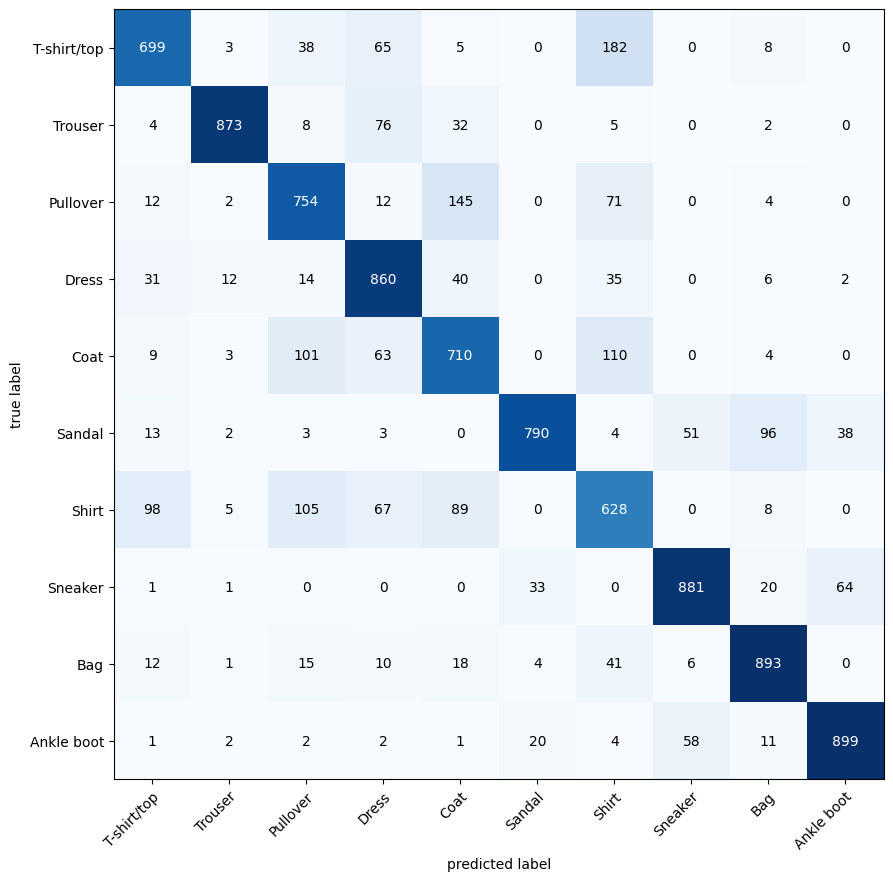

In [31]:
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10,10),
                                cmap=plt.cm.Blues)
plt.show()